In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Bias Variance Tradeoff

This notebook will walk through one of the most fundamental concepts in machine learning, the bias variance tradeoff, by letting you experiment with various settings of hyperparameters for decision trees and SVMs. 

Note: In this homework, you will be seeing types of ML models (eg: decision trees) that we haven't covered in lecture. We hope that through this homework, you will see how each model has various hyper parameters that can be tuned to determine how much the model fits to the training data set, rather than focusing on how exactly the models work. Here are lecture slides from previous offerings of the class that go over decision trees and SVMs in more detail if you are interested:
    * Decision Trees: https://github.com/mlberkeley/Machine-Learning-Decal-Spring-2018/blob/master/Lecture%205/lecture5.pdf
    * SVMS: https://github.com/mlberkeley/Machine-Learning-Decal-Spring-2018/blob/master/Lecture%206/Lecture%206%20Slides.pdf
    

### Overview of Decision Trees

A decision tree is a model with a tree structure, that has a collection of if, then statements in its internal nodes. A new data point is routed through the tree based on the answer to the if, then statements until it reaches a leaf node, which represents the class. 

<img src="decision_tree.png">

To learn the features and values to split on, we greedily find the feature and value that best splits the data in the parent, so the child nodes can have more homogenous class values. This is formally known as minimizing entropy.

If left unconstrained, a decision tree can form as many layers as required to perfectly memorize the training dataset (eg: have exactly one training example in each leaf node). This results in a high variance model. To improve the generalization ability of decision trees, we can use various heuristics to limit the expressive capacity of the tree. Some examples are:
* Early stopping - limit the depth of the tree, or the threshold the purity of the classes of the leaves; limiting the depth of the tree, requiring a minimum number of samples per leaf, and setting the max number of nodes per leaf all prevent the tree from growing fully and reduce the variance
* Pruning - create the full tree and greedily remove trees to improve validation accuracy

We will now play around with various hyperparameters of decision trees using the Iris Dataset.

First load the iris dataset into a pandas dataframe.

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

We will then add the species label to each datapoint using the encoding given in the dataset to understand what the overall dataset looks like.

In [3]:
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Split the dataframe into training and validation data.

In [4]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
train, test = df[df['is_train']==True], df[df['is_train']==False]
train = train.drop(['is_train'], axis = 1)
test = test.drop(['is_train'], axis = 1)

Separate the labels and feature from both the training and test datasets and refactorize the labels

In [5]:
train_features = train[train.columns[:4]]
train_labels = pd.factorize(train['species'])[0]
test_features = test[test.columns[:4]]
test_labels = pd.factorize(test['species'])[0]

Create a basic decision tree which minimizes entropy and fit it to the training data.

In [6]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Compute the training and validation accuracies. You should notice the decision tree gets a higher training accuracy than validation. Decision trees have the capability to fit each training point accurately, so if left unregulated the tree will probably end up overfitting to the training set.

In [7]:
clf.score(train_features, train_labels)

1.0

In [8]:
clf.score(test_features, test_labels)

0.9375

We will now use Grid Search to find a good set of hyperparameters which attempt to regualize the tree. Grid search allows us to pick the combination of hyperparameters that results in the best model. Feel free to play around with the parameters of grid search to find a better tree.

In [64]:
parameters = {"min_samples_split": [2, 10],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
gridsearch = GridSearchCV(clf, parameters)
gridsearch.fit(train_features, train_labels)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 10], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
best_tree = gridsearch.best_estimator_ 
best_tree.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

TODO: Report the values of the hyperparameters that produced the best tree. Where do the final hyperparameters fall in the range that you tested? Why is this so? What is the tradeoff between regularizing the model and increasing its training accuracy?

Your answer here:

- min_sample_split = 2
- max_depth = None
- min_samples_leaf = 1
- max_leaf_nodes = None
- When regularizing the model, the training accuracy will decrease

Compute the training and validation accuracies. On a dataset like Iris, the unregularized decision tree may already achieve the highest validation accuracy, but this method of regularization is useful when using decision trees for more complex tasks.

In [66]:
best_tree.score(train_features, train_labels)

1.0

In [67]:
best_tree.score(test_features, test_labels)

0.9375

### Support Vector Machines
We will now use the SVM implementation in sklearn to classify 2D datasets and understand how to tune the hyperparameters of SVMS. This part of the notebook is adapted from http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise6.ipynb

##### How to Choose C
Large C:
* Goal is to misclassify few training points
* Often results in small margins
* Very sensitive to outliers
* Risk of overfitting

Small C:
* Maximizes margin at cost of misclassifying training data points
* Risk of underfitting

We will now look at a nonlinear dataset:

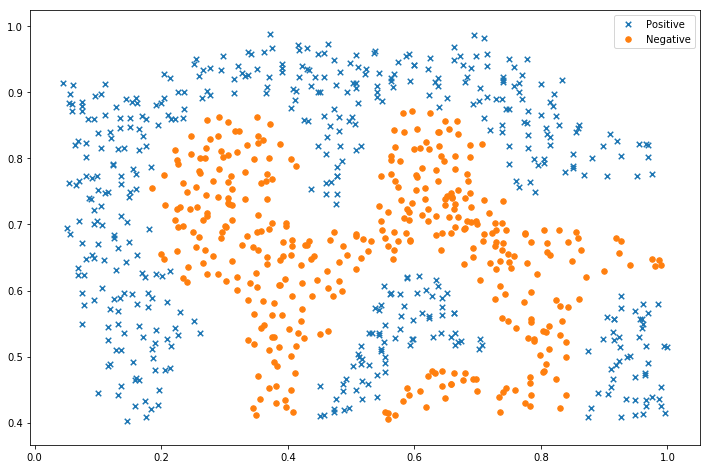

In [68]:
raw_data = loadmat('ex6data2.mat')

data = pd.DataFrame(raw_data['X'], columns=['X1', 'X2'])
data['y'] = raw_data['y']

positive = data[data['y'].isin([1])]
negative = data[data['y'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['X1'], positive['X2'], s=30, marker='x', label='Positive')
ax.scatter(negative['X1'], negative['X2'], s=30, marker='o', label='Negative')
ax.legend()

For this data set we'll build a support vector machine classifier using the built-in RBF kernel and examine its accuracy on the training data. To visualize the decision boundary, this time we'll shade the points based on the predicted probability that the instance has a negative class label. We'll see from the result that it gets most of them right.

In [69]:
from sklearn import svm
svc = svm.SVC(C=100, gamma=10, probability=True)
svc

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9698725376593279

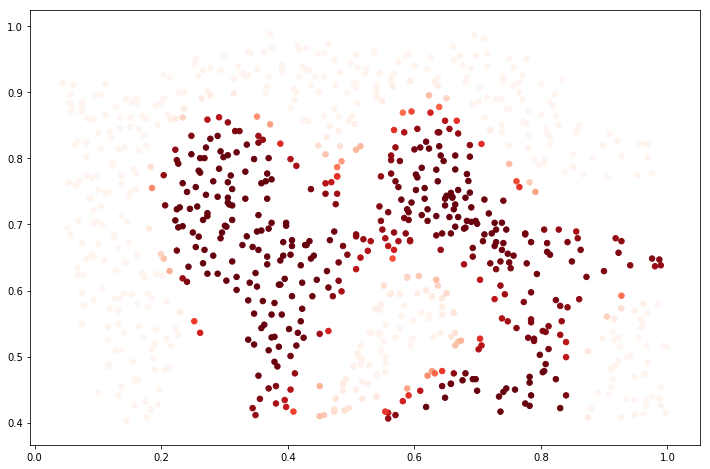

In [71]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds')

TODO: Fill in the following function to use grid search to find the optimal value of C and gamma (hyperparameter of the RBF kernel):

In [89]:
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds):
    # Fill in the dots
    Cs = np.arange(1, 100, 1)
    gammas = np.arange(1, 50, 1)
    param_grid = {'C': Cs, 'gamma' : gammas}
    search = grid_search.GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    search.fit(X, y)
    search.best_params_
    return search.best_params_

In [90]:
svc_param_selection(data[['X1', 'X2']], data['y'], 5)

{'C': 12, 'gamma': 32}

TODO: Based on how you chose potential values to search over, how do you know you found a good value of C and gamma?

Your answer here:

- I have first tried every possible integer values in (1, 100) for Cs and (1, 50) for gammas. The corresponding optimization problem is a convex programming problem. The optimal value is in the interior of search region, hence the C=12, gamma=32 is global optima. 

TODO: Use your optimal values of C and gamma to train the SVM:

In [93]:
# Fill in your optimal values of C and gamma; You should achieve a higher accuracy than before
svc = svm.SVC(C=12, gamma=32, probability=True)
svc

SVC(C=12, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=32, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9942062572421785

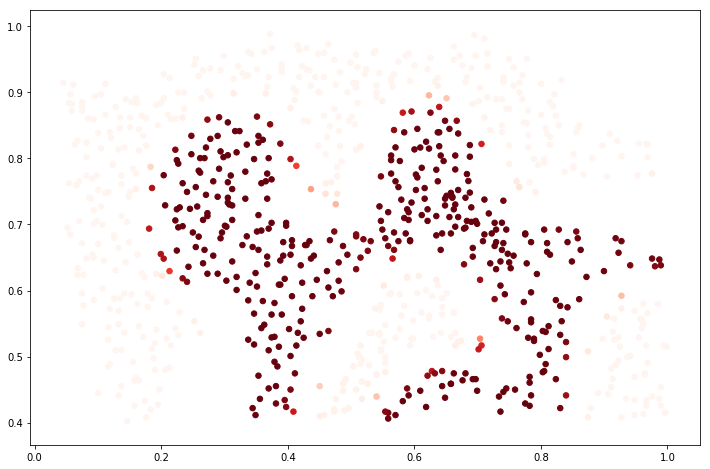

In [95]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds');

TODO: For a fixed value of C, modify the value of gamma and see how the model predicts on the training set. Do higher or lower values of gamma correspond to a high variance model?

For more information of the RBF kernel and its hyperparameters, you can look at:
* Slides 33-34 of https://github.com/mlberkeley/Machine-Learning-Decal-Spring-2018/blob/master/Lecture%206/Lecture%206%20Slides.pdf


In [102]:
svc = svm.SVC(C=10, gamma=30, probability=True)
svc

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=30, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [103]:
svc.fit(data[['X1', 'X2']], data['y'])
svc.score(data[['X1', 'X2']], data['y'])

0.9930475086906141

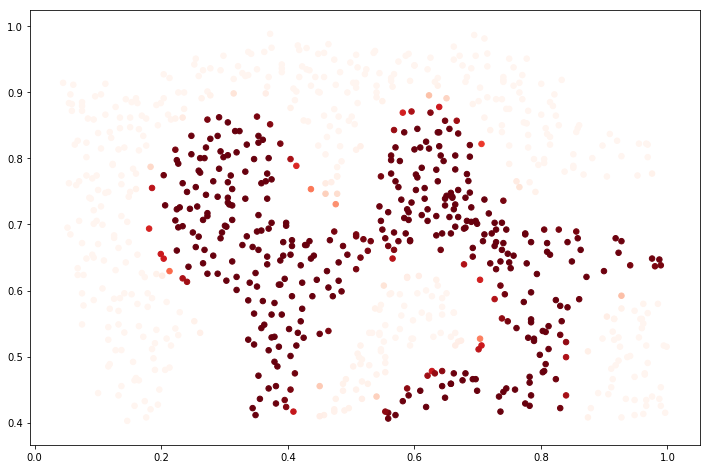

In [104]:
data['Probability'] = svc.predict_proba(data[['X1', 'X2']])[:,0]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(data['X1'], data['X2'], s=30, c=data['Probability'], cmap='Reds');

Your answer here:

- The higher variance correspond to lower variance. 